In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,  # Imported make_scorer
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('training.csv')
df

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand


In [3]:
# Check if all values in the 'snow' column are zero
if (df['snow'] == 0).all():
    print("Every value in the 'snow' column is zero.")
else:
    print("Not every value in the 'snow' column is zero.")


Every value in the 'snow' column is zero.


In [4]:
# Drop the 'snow' column
df = df.drop(columns=['snow'])
print("'snow' column removed successfully.")

'snow' column removed successfully.


In [5]:
# 1. Handle Missing Values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)


Missing Values in Each Column:
hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64


In [6]:
# Handle Target Variable Encoding
df['increase_stock'] = df['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1})

# Cyclic Encoding for 'hour_of_day', 'day_of_week', and 'month'
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [7]:
# 3. Split the dataset into training and testing sets (80%-20%) with random_state=32 for reproducibility
X = df.drop(columns=['increase_stock'])
y = df['increase_stock']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

print(y)

# Display the updated DataFrame with PCA components
print("Shape of X_train after PCA:")
print(X_train.shape)

print("Shape of y_train:")
print(y_train.shape)


0       0
1       0
2       0
3       0
4       0
       ..
1595    0
1596    0
1597    0
1598    1
1599    0
Name: increase_stock, Length: 1600, dtype: int64
Shape of X_train after PCA:
(1280, 20)
Shape of y_train:
(1280,)


In [8]:
# 4. Handling Outliers using Isolation Forest (for highly skewed variables)
features = ['precip', 'snowdepth', 'visibility']
X_outlier = pd.concat([X_train[features], X_test[features]], axis=0)

iso_forest = IsolationForest(contamination=0.05)  # Set the contamination based on data
outliers = iso_forest.fit_predict(X_outlier)

X_train['outlier'] = np.where(outliers[:len(X_train)] == -1, 1, 0)
X_test['outlier'] = np.where(outliers[len(X_train):] == -1, 1, 0)

# Filter out the outliers from both training and test sets
X_train = X_train[X_train['outlier'] == 0]
y_train = y_train[X_train.index]  # Align y_train to X_train after filtering outliers
X_test = X_test[X_test['outlier'] == 0]
y_test = y_test[X_test.index]  # Align y_test to X_test after filtering outliers

# Display the updated DataFrame with PCA components
print("Shape of X_train after PCA:")
print(X_train.shape)

print("Shape of y_train:")
print(y_train.shape)

Shape of X_train after PCA:
(1214, 21)
Shape of y_train:
(1214,)


In [9]:
# 5. Handle Multicollinearity using 
'''
features_for_vif = X_train.select_dtypes(include=[np.number]).drop(columns=['outlier'])

vif_data = pd.DataFrame()
vif_data['Feature'] = features_for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(features_for_vif.values, i) for i in range(len(features_for_vif.columns))]

high_vif_features = vif_data[vif_data['VIF'] > 10]
print("Features with High VIF (>10):")
print(high_vif_features)

# Apply PCA to reduce features with high multicollinearity
# Keep the features that were not flagged for high VIF
features_for_pca = features_for_vif.drop(columns=high_vif_features['Feature'])

# Standardize the data before PCA
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(X_train[features_for_pca.columns])

# Apply PCA to the training data
pca = PCA(n_components=0.95)  # Keeps 95% of the variance
pca_features_train = pca.fit_transform(scaled_features_train)

# Add the PCA-transformed features back to the training dataframe
df_pca_train = pd.DataFrame(pca_features_train, columns=[f'PCA_{i+1}' for i in range(pca_features_train.shape[1])])
X_train = X_train.reset_index(drop=True)  # Ensure the index is reset before concatenation
X_train = pd.concat([X_train, df_pca_train], axis=1)

# Apply the same scaler and PCA transformation to the test data
scaled_features_test = scaler.transform(X_test[features_for_pca.columns])
pca_features_test = pca.transform(scaled_features_test)

# Add the PCA-transformed features back to the test dataframe
df_pca_test = pd.DataFrame(pca_features_test, columns=[f'PCA_{i+1}' for i in range(pca_features_test.shape[1])])
X_test = X_test.reset_index(drop=True)  # Ensure the index is reset before concatenation
X_test = pd.concat([X_test, df_pca_test], axis=1)

# Optionally drop the original features that were replaced by PCA
X_train = X_train.drop(columns=features_for_pca.columns)
X_test = X_test.drop(columns=features_for_pca.columns)

# Display the updated DataFrame with PCA components
print("Shape of X_train after PCA:")
print(X_train.shape)

print("Shape of y_train:")
print(y_train.shape)
'''


'\nfeatures_for_vif = X_train.select_dtypes(include=[np.number]).drop(columns=[\'outlier\'])\n\nvif_data = pd.DataFrame()\nvif_data[\'Feature\'] = features_for_vif.columns\nvif_data[\'VIF\'] = [variance_inflation_factor(features_for_vif.values, i) for i in range(len(features_for_vif.columns))]\n\nhigh_vif_features = vif_data[vif_data[\'VIF\'] > 10]\nprint("Features with High VIF (>10):")\nprint(high_vif_features)\n\n# Apply PCA to reduce features with high multicollinearity\n# Keep the features that were not flagged for high VIF\nfeatures_for_pca = features_for_vif.drop(columns=high_vif_features[\'Feature\'])\n\n# Standardize the data before PCA\nscaler = StandardScaler()\nscaled_features_train = scaler.fit_transform(X_train[features_for_pca.columns])\n\n# Apply PCA to the training data\npca = PCA(n_components=0.95)  # Keeps 95% of the variance\npca_features_train = pca.fit_transform(scaled_features_train)\n\n# Add the PCA-transformed features back to the training dataframe\ndf_pca_tra

In [10]:
# Ensure that the number of rows in X_train and y_train match after filtering outliers
print("Shape of X_train after filtering outliers:", X_test.shape)
print("Shape of y_train after filtering outliers:", y_test.shape)

# Display a sample of the filtered data to check alignment
print("\nSample of filtered X_train:")
print(X_train.head())  # Displaying the first few rows of X_train

print("\nCorresponding values in y_train:")
print(y_train.head())  # Displaying the corresponding target values


Shape of X_train after filtering outliers: (306, 21)
Shape of y_train after filtering outliers: (306,)

Sample of filtered X_train:
      hour_of_day  day_of_week  month  holiday  weekday  summertime  temp  \
575            21            5      1        0        0           0  -4.5   
1506            5            2      7        0        1           1  22.7   
795            22            5      8        0        0           1  25.8   
622             8            5      7        0        0           1  25.5   
195             4            2      2        0        1           0  -0.4   

       dew  humidity  precip  ...  windspeed  cloudcover  visibility  \
575  -17.8     34.71   0.000  ...       29.5         0.0        16.0   
1506  19.9     84.56   0.289  ...        4.8        58.1        16.0   
795   20.7     73.44   0.000  ...        0.0        79.3        16.0   
622   20.0     71.92   0.000  ...       16.0        81.3        16.0   
195   -5.8     66.77   0.000  ...        4.8 

In [11]:
# Define the classifier
knn = KNeighborsClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Define a custom scorer
scorer = make_scorer(f1_score, pos_label=1)  # Specify `pos_label` if targeting a specific class

# Perform GridSearchCV with 5-fold cross-validation and the custom scorer
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scorer, verbose=1)
grid_search.fit(X_train, y_train)

# Output the best hyperparameters and their corresponding score
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)
print("Best F1 Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters from GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best F1 Score:
0.5471917487107361



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       250
           1       0.57      0.48      0.52        56

    accuracy                           0.84       306
   macro avg       0.73      0.70      0.71       306
weighted avg       0.83      0.84      0.83       306



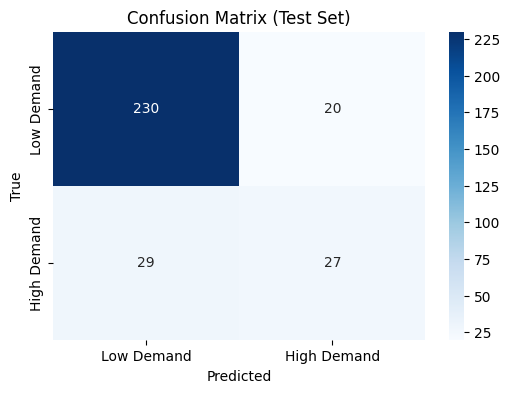

In [12]:
# 7. Evaluate the Model
best_knn = grid_search.best_estimator_

y_test_pred = best_knn.predict(X_test) 

print("\nClassification Report (Test Set):") 
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Demand', 'High Demand'], yticklabels=['Low Demand', 'High Demand'])
plt.title('Confusion Matrix (Test Set)')  
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


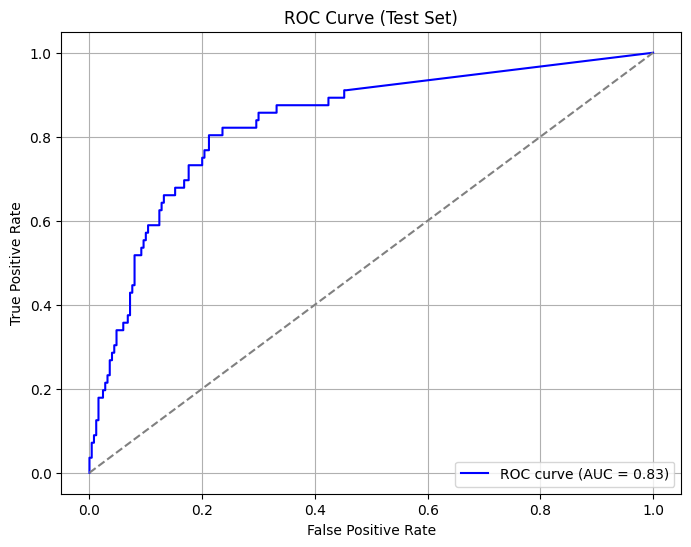

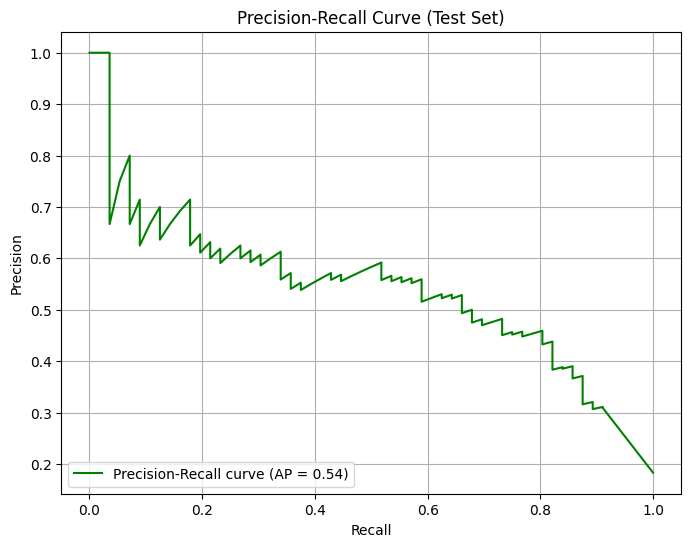

In [13]:
# 8. Plot ROC Curve and Precision-Recall Curve for our prediction

# Predict probabilities for the test set
y_test_prob = best_knn.predict_proba(X_test)[:, 1]  # changed to X_test (no scaling applied)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('ROC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
avg_precision = average_precision_score(y_test, y_test_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
